<a href="https://colab.research.google.com/github/kev-fung/Algothon2019/blob/master/exploratory_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
!pip install pycm livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'Normalize', 'mean', 'std']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [83]:
from sklearn.metrics import r2_score, max_error
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import csv
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset 
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage, RandomResizedCrop, RandomAffine
import random
import itertools


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


##Define Train, Validate, Test Functions



In [0]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0., 0.
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        
        train_loss += loss*X.size(0)
        train_accuracy += max_error(y.cpu().numpy(), output.detach().cpu().numpy())*X.size(0)
  
        optimizer.step()
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            
            output = model(X)

            loss = criterion(output, y)
            validation_loss += loss*X.size(0)
            validation_accuracy += max_error(y.cpu().numpy(), output.detach().cpu().numpy())*X.size(0)
  
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            
            y_pred = model(X)
        
#             y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

## Tensor Dataset

In [0]:
class TensorDataset(Dataset):
    def __init__(self, data, targets, transform=None, mean=None, std=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data.reshape(-1)
        self.targets = targets
        self.mean = mean
        self.std = std
#         self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        return ((sample-self.mean)/self.std).float(), label.float()

## Model Development

In [0]:
class model1(nn.Module):
  def __init__(self):
    
    super(model1, self).__init__()
    self.input = nn.Linear(1,5)
    self.linear1 = nn.Linear(5,5)
    self.output = nn.Linear(5,1)
    self.act = nn.Tanh()
    
    
  def forward(self, x):
    x = self.act(self.input(x))
    x = self.act(self.linear1(x))
    x = self.act(self.output(x))
    
    return x

## Import Data

In [87]:
# Input data should be [mx1]


# train_data = 
# validate_data = 
# test_data = 

x = np.arange(0,100)
print(x)
y = 2*x + 1
print(y)

testx = np.arange(100,200)
print(testx)
testy = 2*testx + 1

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
[  1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35
  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71
  73  75  77  79  81  83  85  87  89  91  93  95  97  99 101 103 105 107
 109 111 113 115 117 119 121 123 125 127 129 131 133 135 137 139 141 143
 145 147 149 151 153 155 157 159 161 163 165 167 169 171 173 175 177 179
 181 183 185 187 189 191 193 195 197 199]
[100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170

## Train and Validate Model

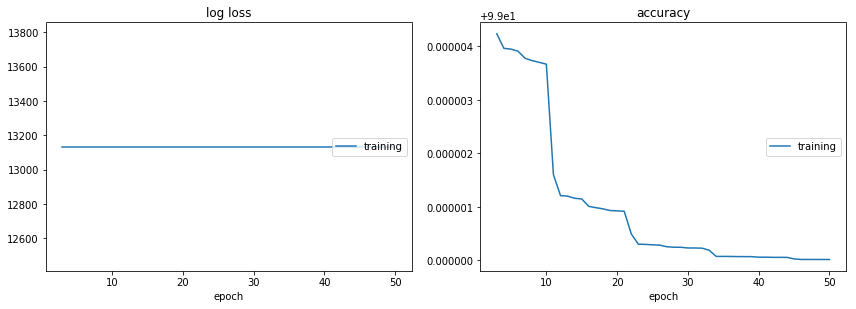

log loss:
training   (min: 13134.000, max: 13139.165, cur: 13134.000)

accuracy:
training   (min:   99.000, max:   99.032, cur:   99.000)


In [88]:
def run(in_model, n_epochs, seed, lr, weight_decay):
    model = in_model().to(device)

    set_seed(seed)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)
    criterion = nn.MSELoss()

    liveloss = PlotLosses()
    for epoch in range(n_epochs):
        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

#         validation_loss, validation_accuracy = validate(model, criterion, test_loader)
#         logs['val_' + 'log loss'] = validation_loss.item()
#         logs['val_' + 'accuracy'] = validation_accuracy.item()
        print(epoch)
        liveloss.update(logs)
        liveloss.draw()
    
    return model
  
#     test_loss, test_acc = validate(model, criterion, test_loader)
#     print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_acc.item())
#     print("")

# Split data into train and test sets, labels and features
# Change the data!!!!

xtrain, ytrain = x.astype(float), y.astype(float)
xtrain, ytrain = torch.from_numpy(xtrain), torch.from_numpy(ytrain)

xtest, ytest = testx.astype(float), testy.astype(float)
xtest, ytest = torch.from_numpy(xtest), torch.from_numpy(ytest)


# X_train, y_train = X_train_orig.astype(float), y_train_orig
# X_test, y_test = X_test_orig.astype(float), y_test_orig

# X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train)
# X_test, y_test = torch.from_numpy(X_test).float(), torch.from_numpy(y_test)

mean, std = torch.mean(xtrain), torch.std(xtrain)

# # Assemble tensor datasets
train_ds = TensorDataset(xtrain, ytrain.long(), mean=mean, std=std)
test_ds = TensorDataset(xtest, ytest.long(), mean=mean, std=std)

# # Assemble dataloaders
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0)

trained_model = run(model1, n_epochs=50, seed=42, lr=0.1, weight_decay=0.)
pred, truth = evaluate(trained_model, test_loader)

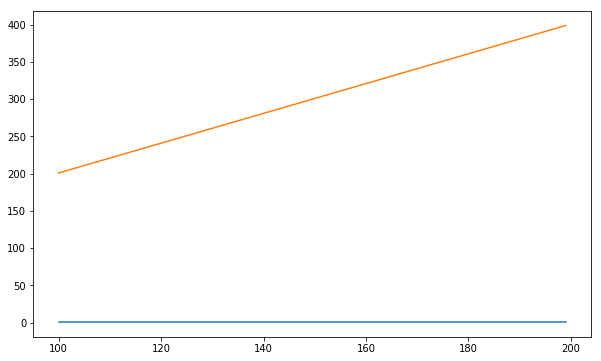

In [89]:
fig, axs = plt.subplots(1,1,figsize=(10,6))
axs.plot(xtest, pred)
axs.plot(xtest, truth)